<a href="https://colab.research.google.com/github/ayrna/ap2122/blob/main/series_temporales/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Series temporales en Python

Vamos a utilizar fundamentalmente dos bibliotecas:

- Pandas: https://pandas.pydata.org/pandas-docs/stable/timeseries.html
- scipy http://www.statsmodels.org/devel/tsa.html

## Estacionaridad

Un serie temporal (ST) se dice que es estacionaria si sus propiedades estadísticas, tales como la media, la varianza y la covarianza, son constantes a lo largo del tiempo.

- Media constante.
- Varianza constante.
- La covarianza entre dos instantes depende del número de observaciones que les separan, no del instante de tiempo.

### ¿Que es lo que provoca la no estacionaridad de una ST?.

Hay dos razones fundamentales:

1. La tendencia -- La media varía a lo largo del tiempo. Por ejemplo, el número de pasajeros en general ha crecido conforme han ido pasando los años.

2. Estacionalidad -- Variaciones que suceden en periodos específicos de tiempo. Por ejemplo, las personas pueden tener una tendencia a comprar coches en determinadas épocas del año o meses, debido a las pagas extras o a las vacaciones.

## Estructura de una serie temporal en Pandas

- Una ST es similar a una lista o un *array* en Python.
- Representa una serie de valores (numéricos o de otro tipo) en forma de columna de datos.
- Proporciona alguna funcionalidad adicional (métodos y operadores), que hacen que sea una versión más potente que una lista.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Crear una serie temporal a partir de una lista
ser = pd.Series([1, 3])
print(ser)

# Usar una serie de cadenas como índice
prices = {'apple': 4.99,
         'banana': 1.99,
         'orange': 3.99}
ser = pd.Series(prices)
print(ser)

x = pd.Series(np.arange(1,3), index=[x for x in 'ab'])
print(x)
print(x['b'])

0    1
1    3
dtype: int64
apple     4.99
banana    1.99
orange    3.99
dtype: float64
a    1
b    2
dtype: int64
2


## Análisis de series temporales a partir de Google Trends

Inspirado en: https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

Utilizaremos los datos de Google Trends de palabras clave como 'diet' y 'gim' para ver como varían a lo largo del tiempo, al mismo tiempo que aprendemos sobre tendencias y estacionalidad en datos de series temporales.

Los datos se corresponden a una sesión del *Facebook Live code* del 4 de enero de 2018. Se comprueban los datos de Google Trends en referencia a 'diet', 'gym' y 'finance' con la idea de ver como varían en función del tiempo. Nos preguntamos si estos términos son más populares en enero, cuando estamos con los propósitos de año nuevo.

En este tutorial vamos a:
- Leer los datos
- Recodificarlos
- Realizar un análisis exploratorio de los mismos
- Entrenar modelos predictivos

## Leer los datos

In [3]:
try:
    url = "https://raw.githubusercontent.com/datacamp/datacamp_facebook_live_ny_resolution/master/data/multiTimeline.csv"
    df = pd.read_csv(url, skiprows=2)
except:
    df = pd.read_csv("./data/multiTimeline.csv", skiprows=2)

print(df.head())

# Rename columns
df.columns = ['month', 'diet', 'gym', 'finance']

# Describe
print(df.describe())

print(df.info())

     Month  diet: (Worldwide)  gym: (Worldwide)  finance: (Worldwide)
0  2004-01                100                31                    48
1  2004-02                 75                26                    49
2  2004-03                 67                24                    47
3  2004-04                 70                22                    48
4  2004-05                 72                22                    43
             diet         gym     finance
count  168.000000  168.000000  168.000000
mean    49.642857   34.690476   47.148810
std      8.033080    8.134316    4.972547
min     34.000000   22.000000   38.000000
25%     44.000000   28.000000   44.000000
50%     48.500000   32.500000   46.000000
75%     53.000000   41.000000   50.000000
max    100.000000   58.000000   73.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   month    168 non-nu

## Recodificar los datos

Ahora, vamos a convertir la columna 'month' en un `DateTime` y hacer que sea el índice del `DataFrame`.

Hacemos esto porque al ver el resultado del método `.info()` nos damos cuenta que la columna `month` es de tipo `object`. Este tipo genérico encapsula todo desde cadenas a enteros y esto no es lo que queremos cuando examinamos series temporales. Utilizaremos el método `.to_datetime()` para convertir la columna `month` del `DataFrame` a tipo `DateTime`.

¡Ten cuidado! Haz uso del argumento `inplace` cuando estableces el índice del `DataFrame` de forma que los cambios se hagan realmente sobre la copia actual (y no se devuelva una copia modificada).

In [4]:
df.month = pd.to_datetime(df.month)
df.set_index('month', inplace=True)

print(df.head())

            diet  gym  finance
month                         
2004-01-01   100   31       48
2004-02-01    75   26       49
2004-03-01    67   24       47
2004-04-01    70   22       48
2004-05-01    72   22       43


## Análisis exploratorio de los datos

Puedes utilizar la herramienta de visualización de `pandas` `.plot()` para representar tus datos como 3 líneas en una sola figura (una para cada columna, `diet`, `gym` y `finance`).

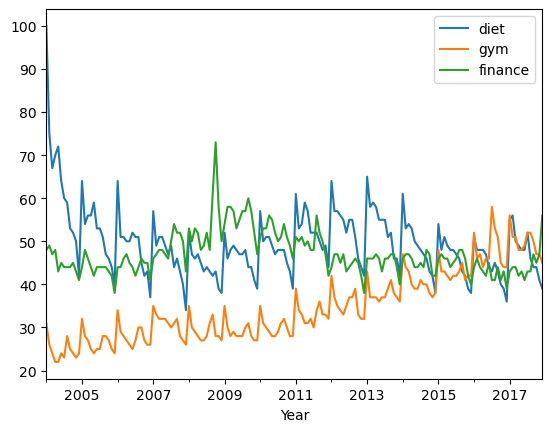

In [5]:
df.plot()
plt.xlabel('Year');

<AxesSubplot:xlabel='month'>

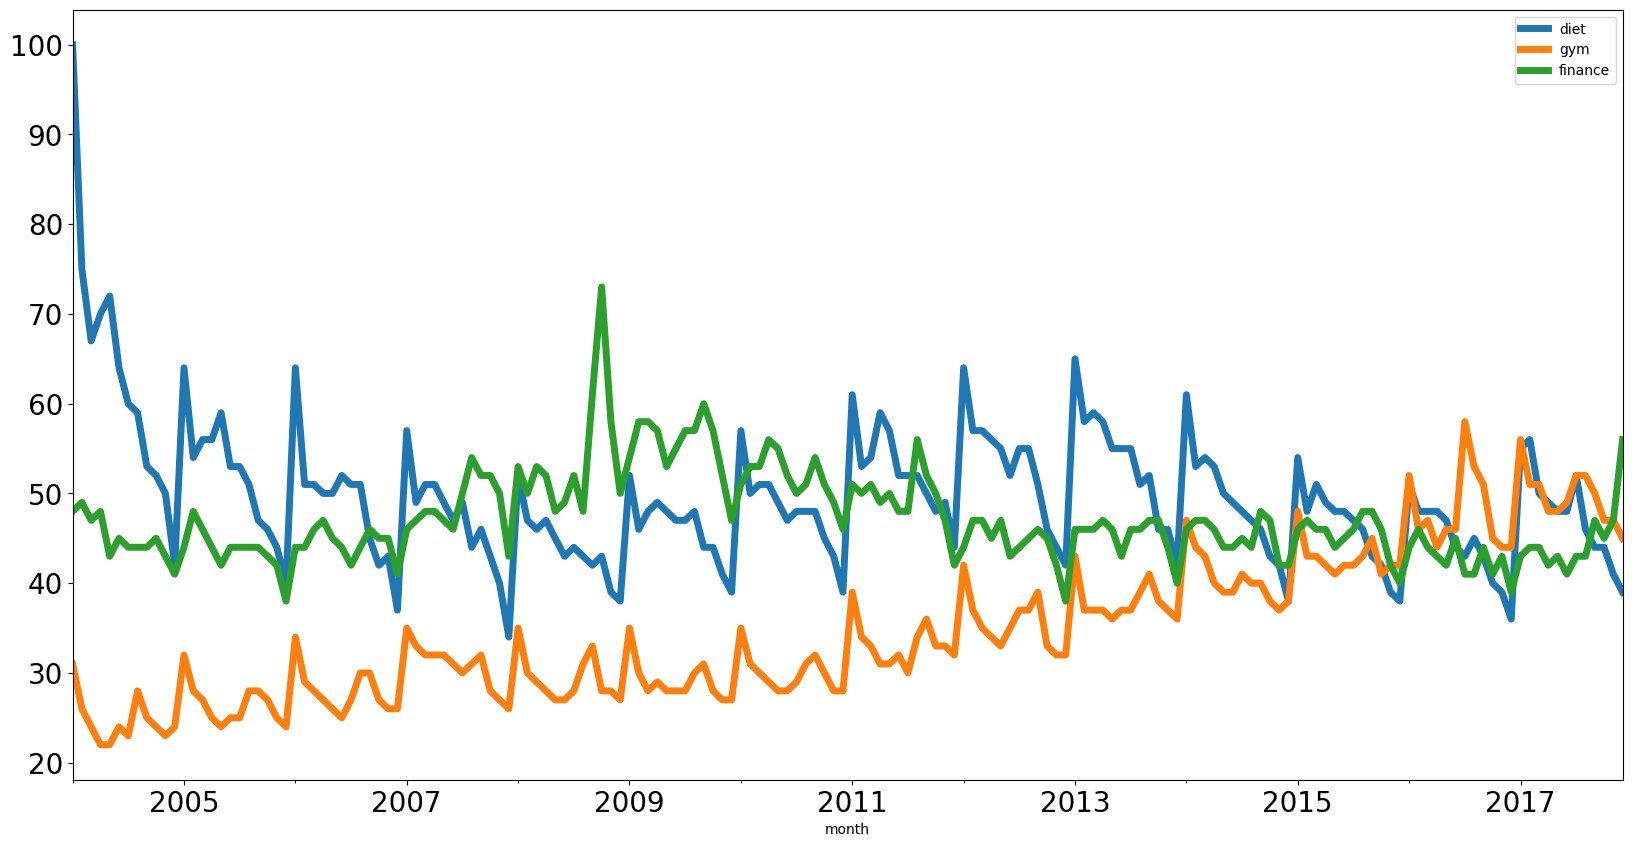

In [6]:
# Cambiar los parámetros de la figura
df.plot(figsize=(20,10), linewidth=5, fontsize=20)

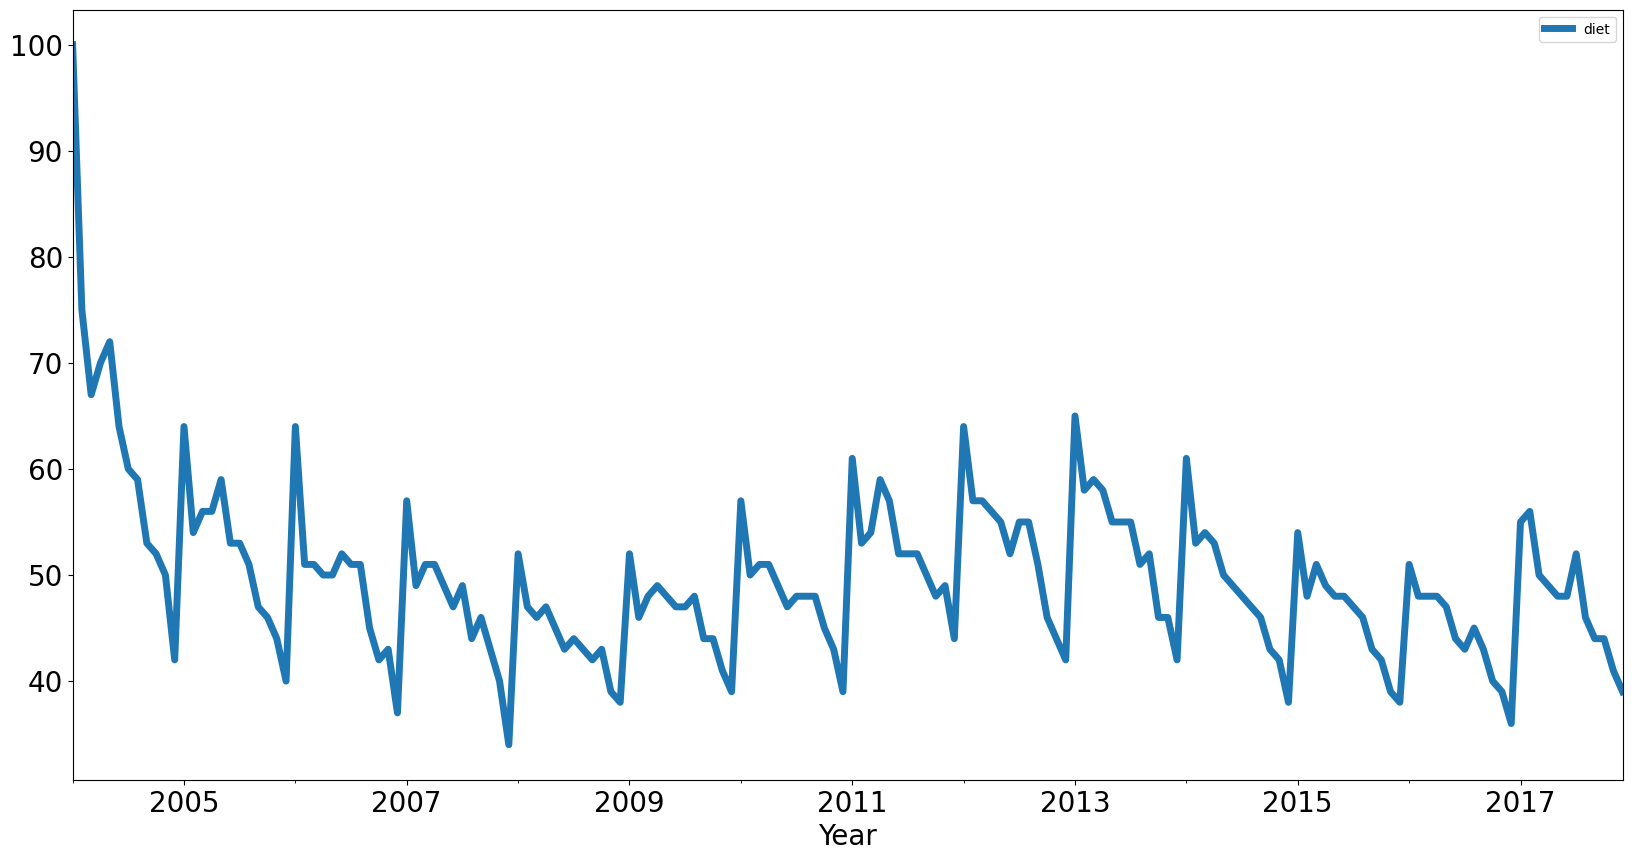

In [7]:
# Representar solo una figura
df[['diet']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

Ten en cuenta que estos datos son relativos. Como se puede leer en Google Trends:

> Numbers represent search interest relative to the highest point on the chart
> for the given region and time.
> A value of 100 is the peak popularity for the term.
> A value of 50 means that the term is half as popular.
> Likewise a score of 0 means the term was less than 1% as popular as the peak.

## Remuestreo, suavizado, obtención de ventanas, medias deslizantes: tendencias

Las medias deslizantes toman, para cada instante de tiempo, la media de los puntos que le rodean. El número de puntos se especifica como un tamaño de ventana.

Consultar el siguiente enlace http://pandas.pydata.org/pandas-docs/stable/timeseries.html

El valor 'A' significa frecuencia anual (tomada a final de año)

<class 'pandas.core.resample.DatetimeIndexResampler'>
month
2004-12-31    63.666667
2005-12-31    51.916667
2006-12-31    48.916667
2007-12-31    46.666667
2008-12-31    44.083333
Freq: A-DEC, Name: diet, dtype: float64
month
2004-01-01          NaN
2004-02-01          NaN
2004-03-01          NaN
2004-04-01          NaN
2004-05-01          NaN
2004-06-01          NaN
2004-07-01          NaN
2004-08-01          NaN
2004-09-01          NaN
2004-10-01          NaN
2004-11-01          NaN
2004-12-01    63.666667
2005-01-01    60.666667
2005-02-01    58.916667
2005-03-01    58.000000
2005-04-01    56.833333
2005-05-01    55.750000
2005-06-01    54.833333
2005-07-01    54.250000
2005-08-01    53.583333
Name: diet, dtype: float64


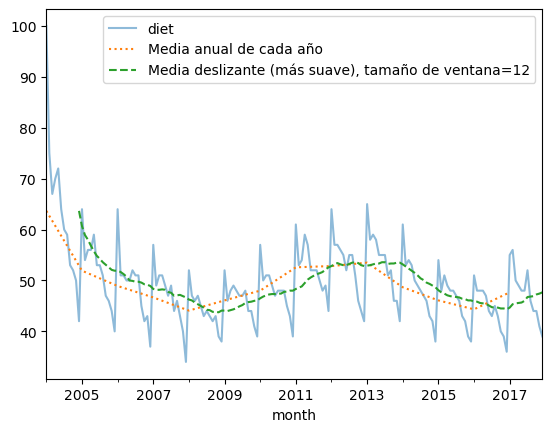

In [8]:
diet = df['diet']

print(type(diet.resample('A')))

diet_resamp_yr = diet.resample('A').mean()
print(diet_resamp_yr.head())
diet_roll_yr = diet.rolling(12).mean()
print(diet_roll_yr.head(20))

ax = diet.plot(alpha=0.5, style='-') # Guardamos los ejes (ax) para reutilizarlos en el resto de plots
diet_resamp_yr.plot(style=':', label='Media anual de cada año', ax=ax)
diet_roll_yr.plot(style='--', label='Media deslizante (más suave), tamaño de ventana=12', ax=ax)
ax.legend();

Podemos hacer la misma operación con `numpy`:

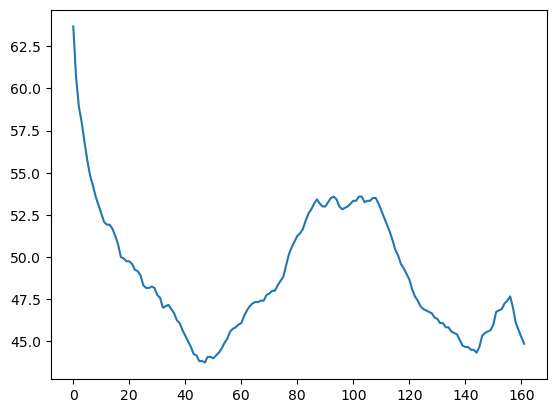

In [9]:
x = np.asarray(df[['diet']])
win = 12
win_half = int(win / 2)
#print([((idx-win_half), (idx+win_half)) for idx in np.arange(win_half, len(x))])

diet_smooth = np.array([x[(idx-win_half):(idx+win_half)].mean() for idx in np.arange(win_half, len(x))])
# Ojo, no estamos saliendo de rango, pero es ignorado por numpy
plt.plot(diet_smooth);

Hacemos un nuevo `DataFrame` que incluya la concatenación de los valores para `diet` y `gym` ya suavizados.

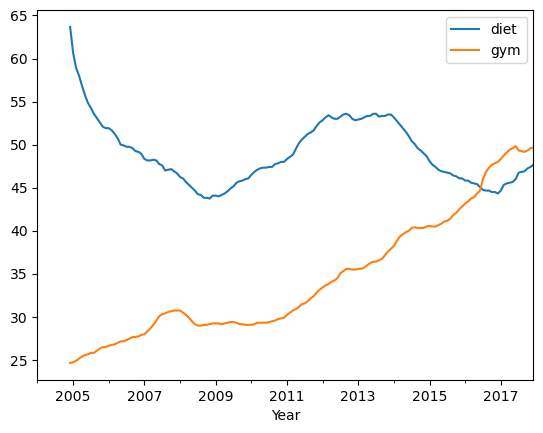

In [10]:
gym = df['gym']

df_avg = pd.concat([diet.rolling(12).mean(), gym.rolling(12).mean()], axis=1)
df_avg.plot()
plt.xlabel('Year');

Eliminar la tendencia de la serie original.

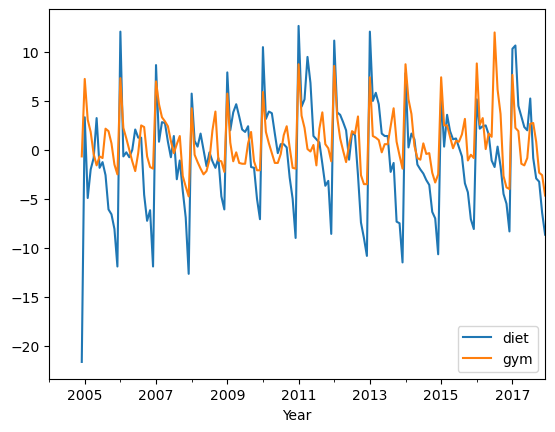

In [11]:
df_dtrend = df[["diet", "gym"]] - df_avg
df_dtrend.plot()
plt.xlabel('Year');

## Diferenciación de primer orden: patrones estacionales

La diferenciación de primer orden nos permite eliminar la tendencia y ver solo los patrones estacionales.

month
2004-01-01    100
2004-02-01     75
2004-03-01     67
2004-04-01     70
2004-05-01     72
Name: diet, dtype: int64
month
2004-01-01      NaN
2004-02-01    100.0
2004-03-01     75.0
2004-04-01     67.0
2004-05-01     70.0
Name: diet, dtype: float64
month
2004-01-01     NaN
2004-02-01   -25.0
2004-03-01    -8.0
2004-04-01     3.0
2004-05-01     2.0
Name: diet, dtype: float64


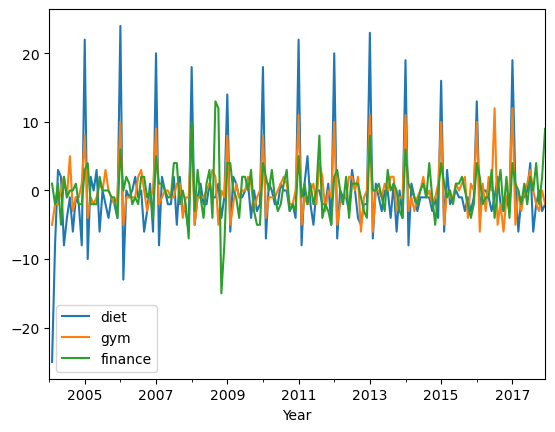

In [12]:
# diff = original - shiftted data
print(diet.head())
print(diet.shift().head()) # Serie con retardo de 1 (X_{t-1})
print(diet.diff().head()) # Serie de diferencias de 1 (X_t-X_{t-1})
assert np.all((diet.diff() == diet - diet.shift())[1:])

df.diff().plot()
plt.xlabel('Year');

## Periodicidad y correlación

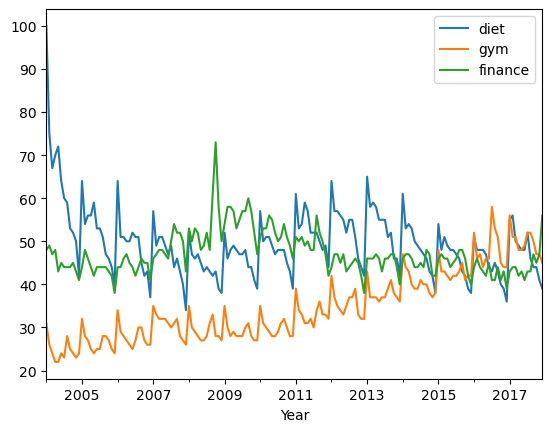

In [13]:
df.plot()
plt.xlabel('Year');

Obtener la matriz de correlaciones

In [14]:
print(df.corr())

             diet       gym   finance
diet     1.000000 -0.100764 -0.034639
gym     -0.100764  1.000000 -0.284279
finance -0.034639 -0.284279  1.000000


¡`diet` y `gym` tienen una correlación negativa!
Recuerda que tienes un componente estacional y uno de tendencia.

- Los componentes de tendencia parecen estar negativamente correlados.
- Los componentes estacionales estaría positivamente correlados.

En realidad, al estar trabajando sobre la serie original, estamos viendo las correlaciones al mismo tiempo.

Correlación estacional: correlación de las diferencias de primer orden de estas STs.

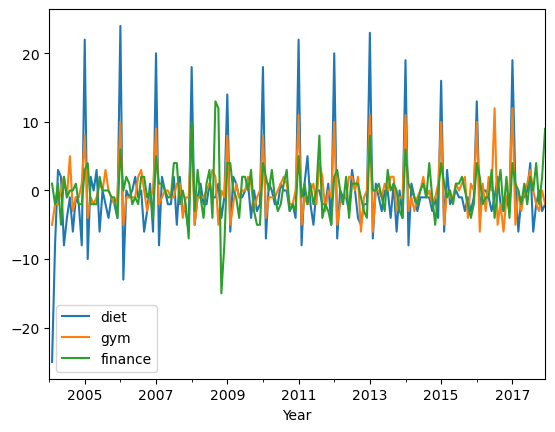

In [15]:
df.diff().plot()
plt.xlabel('Year');

La matriz de correlación es ahora

In [16]:
print(df.diff().corr())

             diet       gym   finance
diet     1.000000  0.758707  0.373828
gym      0.758707  1.000000  0.301111
finance  0.373828  0.301111  1.000000


Para verlo todo mucho más claro, podemos usar el método `seasonal_decompose` que descompone la serie en sus componentes estacional, de tendencia y residual.

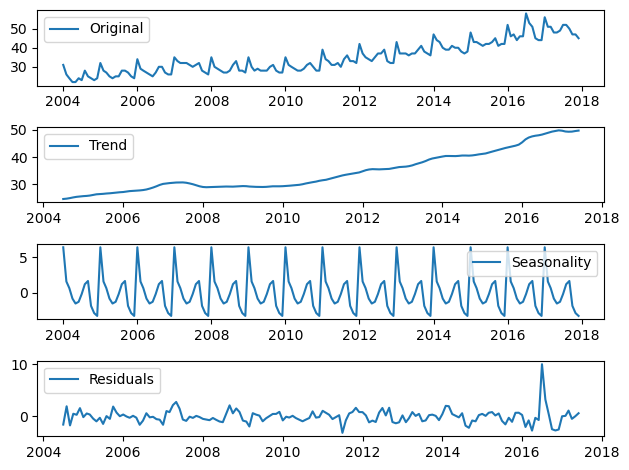

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

x = gym

x = x.astype(float) # force float
decomposition = seasonal_decompose(x)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(x, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Podemos hacer el plot directamente a partir del objeto asociado a la descomposición:

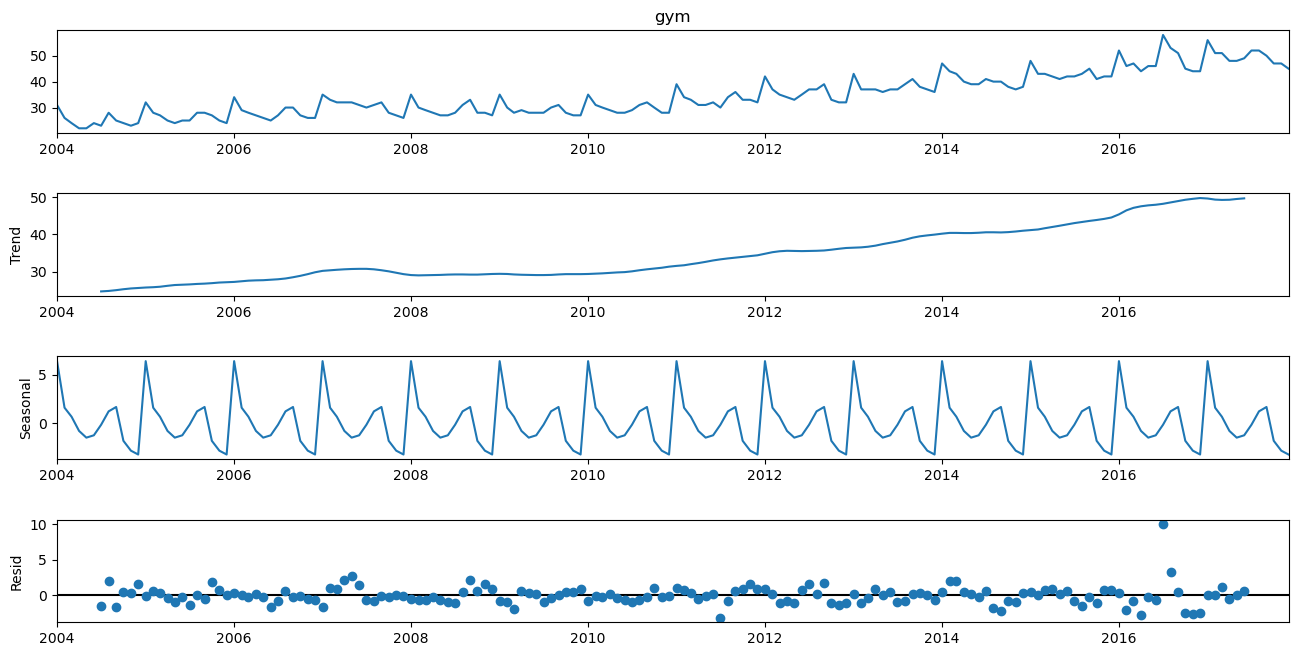

In [18]:
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

## Comprobar la estacionariedad

El método que podemos ver a continuación representa los estadísticos (media y varianza) en ventana deslizante para comprobar de forma cómoda si la varianza tiende a cambiar a lo largo del tiempo:

In [19]:
### Representar los estadísticos para comprobar la estacionariedad
def test_stationarity(timeseries, title):
    
    # Determinar los estadísticos
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='media deslizante');
    ax.plot(rolstd, label='desviación típica deslizante (x10)');
    ax.legend()

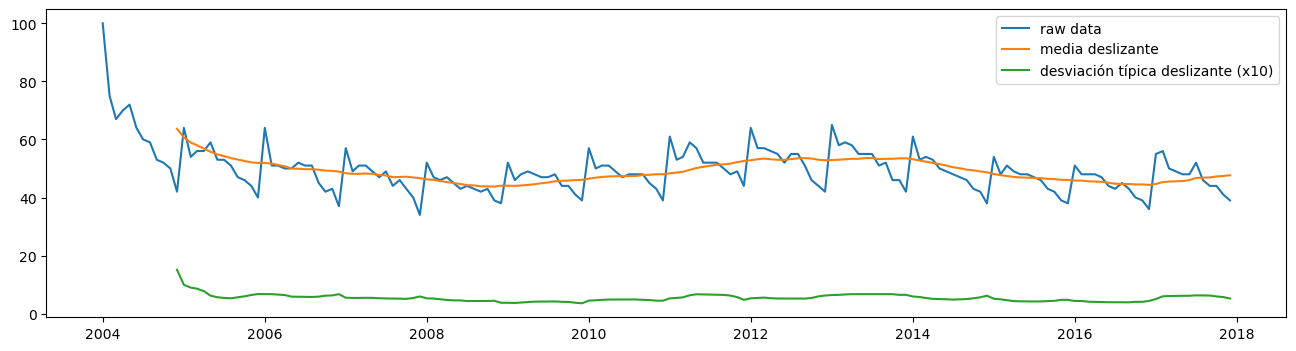

In [20]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(diet,'raw data')

A simple vista no parece que la desviación típica o la media cambien demasiado, pero sería más correcto realizar este estudio usando algún test estadístico, ya que los cambios pueden no ser evidentes debido a la escala del gráfico.

### Test estadístico Augmented Dickey-Fuller (ADF)

El enfoque ADF es esencialmente una prueba de significación estadística que compara el valor $p$ con los valores críticos y realiza pruebas de hipótesis. Mediante esta prueba, podemos determinar si los datos procesados son estacionarios o no con diferentes niveles de confianza.

In [21]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > ¿Es estacionaria la serie {}?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Estadístico = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Valores críticos :')
    for k, v in dftest[4].items():
        print('\t{}: {} - La serie es {} estacionaria con una confianza de {}%'.format(k, v, 'no' if v<dftest[0] else '', 100-int(k[:-1])))

In [22]:
ADF_test(diet,'Datos originales')

 > ¿Es estacionaria la serie Datos originales?
Estadístico = -1.647
P-value = 0.458
Valores críticos :
	1%: -3.473542528196209 - La serie es no estacionaria con una confianza de 99%
	5%: -2.880497674144038 - La serie es no estacionaria con una confianza de 95%
	10%: -2.576878053634677 - La serie es no estacionaria con una confianza de 90%


Para intentar hacer la serie estacionaria, podemos restar la media deslizante y dividir por la desviación típica deslizante:

 > ¿Es estacionaria la serie datos sin tendencia?
Estadístico = -2.266
P-value = 0.183
Valores críticos :
	1%: -3.476597917537401 - La serie es no estacionaria con una confianza de 99%
	5%: -2.8818291230495543 - La serie es no estacionaria con una confianza de 95%
	10%: -2.5775887982253085 - La serie es no estacionaria con una confianza de 90%


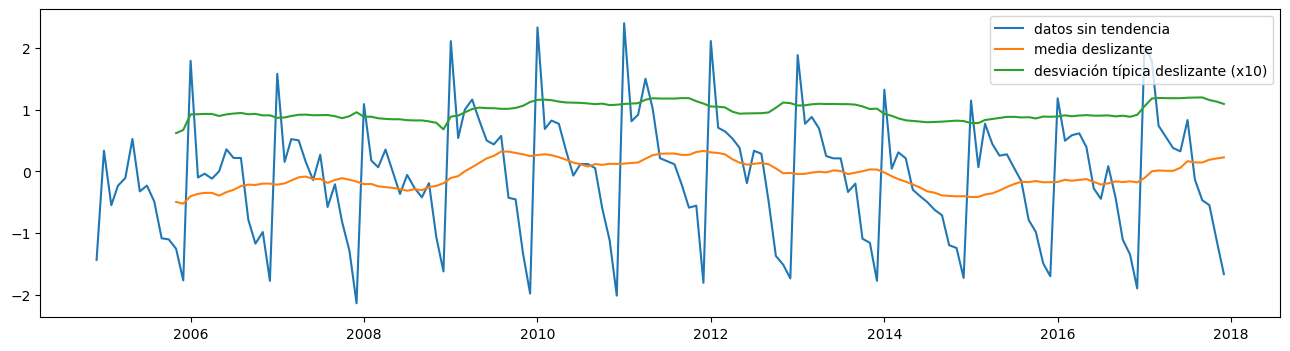

In [23]:
# Eliminar tendencia
diet_detrend =  (diet - diet.rolling(window=12).mean())/diet.rolling(window=12).std()

test_stationarity(diet_detrend,'datos sin tendencia')
ADF_test(diet_detrend,'datos sin tendencia')

Aún así no conseguimos estacionariedad. El problema es que aún tenemos la parte estacional. Una forma de eliminarla es realizar una diferenciación utilizando el periodo correspondiente a la estacionalidad (12 meses en este caso).

 > ¿Es estacionaria la serie datos con retardo de 12 instantes?
Estadístico = -2.330
P-value = 0.162
Valores críticos :
	1%: -3.4776006742422374 - La serie es no estacionaria con una confianza de 99%
	5%: -2.882265832283648 - La serie es no estacionaria con una confianza de 95%
	10%: -2.5778219289774156 - La serie es no estacionaria con una confianza de 90%


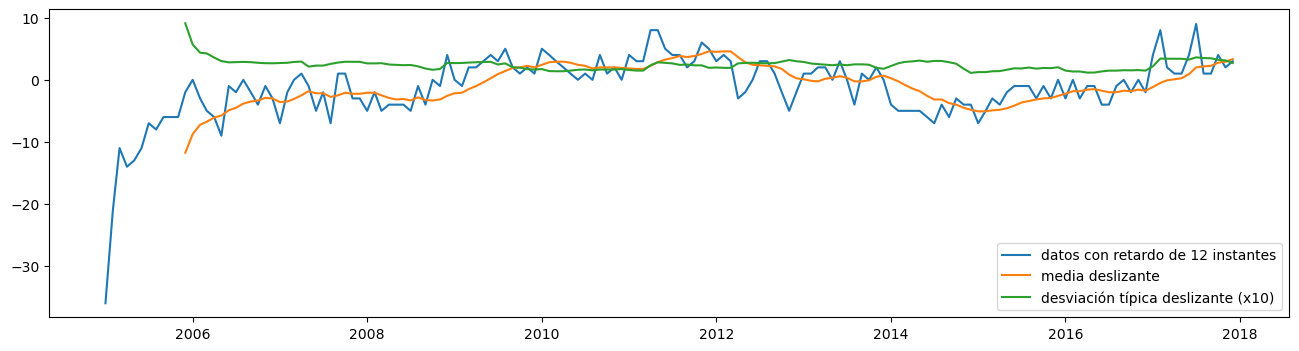

In [24]:
# Differencing
diet_12lag =  diet - diet.shift(12)

test_stationarity(diet_12lag,'datos con retardo de 12 instantes')
ADF_test(diet_12lag,'datos con retardo de 12 instantes')

Seguimos sin obtener una serie estacionaria, porque aún está la tendencia (observa como la media fluctúa bastante). Lo que hay que hacer es combinar las dos técnicas.

 > ¿Es estacionaria la serie 12 lag differenced de-trended data?
Estadístico = -2.994
P-value = 0.035
Valores críticos :
	1%: -3.4816817173418295 - La serie es no estacionaria con una confianza de 99%
	5%: -2.8840418343195267 - La serie es  estacionaria con una confianza de 95%
	10%: -2.578770059171598 - La serie es  estacionaria con una confianza de 90%


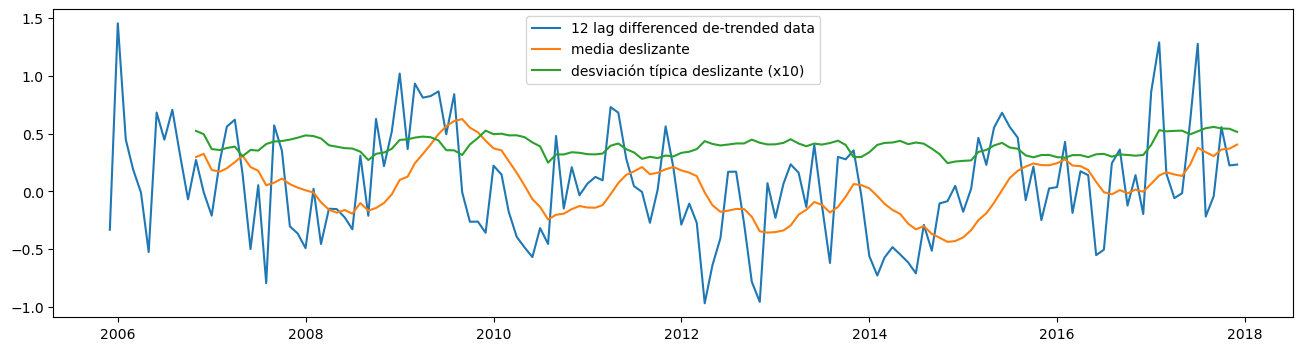

In [25]:
# Eliminar tendencia y diferenciar

diet_12lag_detrend =  diet_detrend - diet_detrend.shift(12)

test_stationarity(diet_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(diet_12lag_detrend,'12 lag differenced de-trended data')

## Autocorrelación

Una ST se dice que es periódica si se repite en intervalos equiespaciados en el tiempo, por ejemplo, cada 12 meses.

La función de autocorrelación (ACF) es una medida de la correlación entre la ST con una versión retardada de la misma. Por ejemplo, si tomamos lag=5, ACF compararía los instantes t6, t7, t8... de la ST con t1, t2, t3...

Existe una función de `pandas` que nos hace una representación de estos valores de autocorrelación:

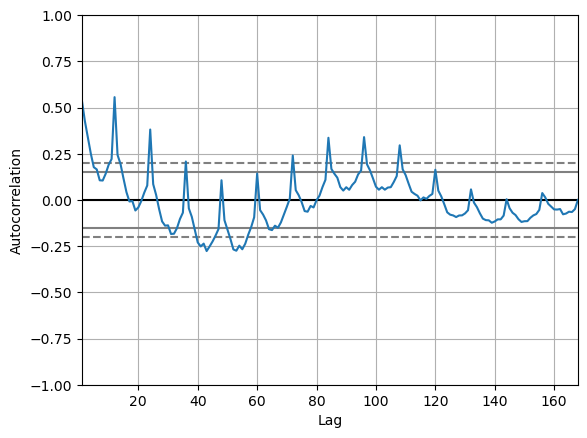

In [26]:
# from pandas.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot

x = df["diet"].astype(float)
autocorrelation_plot(x);

También podemos calcular los valores de ACF:

Text(0.5, 1.0, 'Autocorrelation Function')

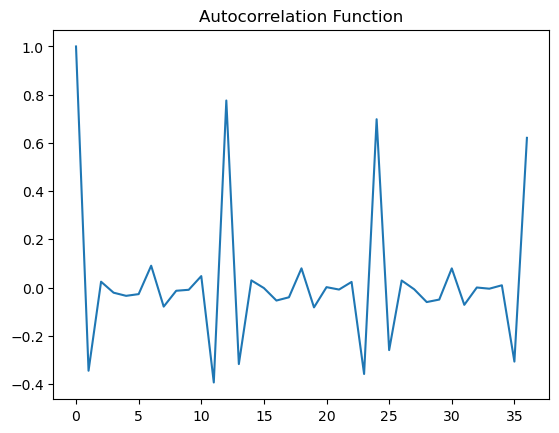

In [27]:
from statsmodels.tsa.stattools import acf

x_diff = x.diff().dropna() # El primer término será NA
lag_acf = acf(x_diff, nlags=36, fft=True)
plt.plot(lag_acf)
plt.title('Autocorrelation Function')

Como se puede observar, el gráfico ACF tiene picos cada 12 meses, lo que quiere decir que la serie está correlada consigo misma de forma anual (enero con enero, febrero con febrero...).

## División en conjuntos de entrenamiento y test

Para estar preparado para evaluar el rendimiento de los modelos que se están considerando para su análisis de series temporales, es importante dividir el conjunto de datos en al menos dos partes.

Una parte será el conjunto de datos de 'Entrenamiento', y la otra parte será el conjunto de datos de 'Test'. A veces se crea un tercer conjunto de datos o un conjunto de datos de 'Validación' que reserva algunos datos para pruebas adicionales.

Para los propósitos de este ejemplo de análisis de series de tiempo, solo tendremos entrenamiento y test.

In [28]:
predict_date='2016-01-01'
diet_to_train = diet[:predict_date] # Datos de entrenamiento (todos los años salvo los dos últimos)
diet_to_test = diet[predict_date:] # Dos últimos años para test
predict_length = len(diet) - len(diet[:predict_date]) # Número de datos en test

## Suavizado exponencial simple (SES)

Adecuado para datos de series temporales sin componentes de tendencia o estacionales.

Este modelo calcula los datos de previsión utilizando medias ponderadas. Un parámetro importante que utiliza este modelo es el parámetro de suavizado: $\alpha$, eligiéndose un valor entre 0 y 1 para determinar el nivel de suavizado. Cuando $\alpha=0$, las previsiones son iguales a la media de los datos históricos.Cuando $\alpha=1$, las previsiones serán iguales al valor de la última observación.

Puede elegir un $\alpha$ específico (por ejemplo, en el código de muestra, utilizaremos $\alpha=0.8$) o utilizar el módulo 'statsmodels' de Python para encontrar automáticamente un valor optimizado para el conjunto de datos.

In [29]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_length):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_length).rename(r'$\alpha={}$'.format(smoothing_level))
    # Valor de alpha fijo
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('El error cuadrático medio con las predicciones para alpha={} es {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_length).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('El error cuadrático medio con las predicciones para alpha automático es {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

/home/pedroa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/pedroa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


El error cuadrático medio con las predicciones para alpha=0.8 es 5.59
El error cuadrático medio con las predicciones para alpha automático es 4.93


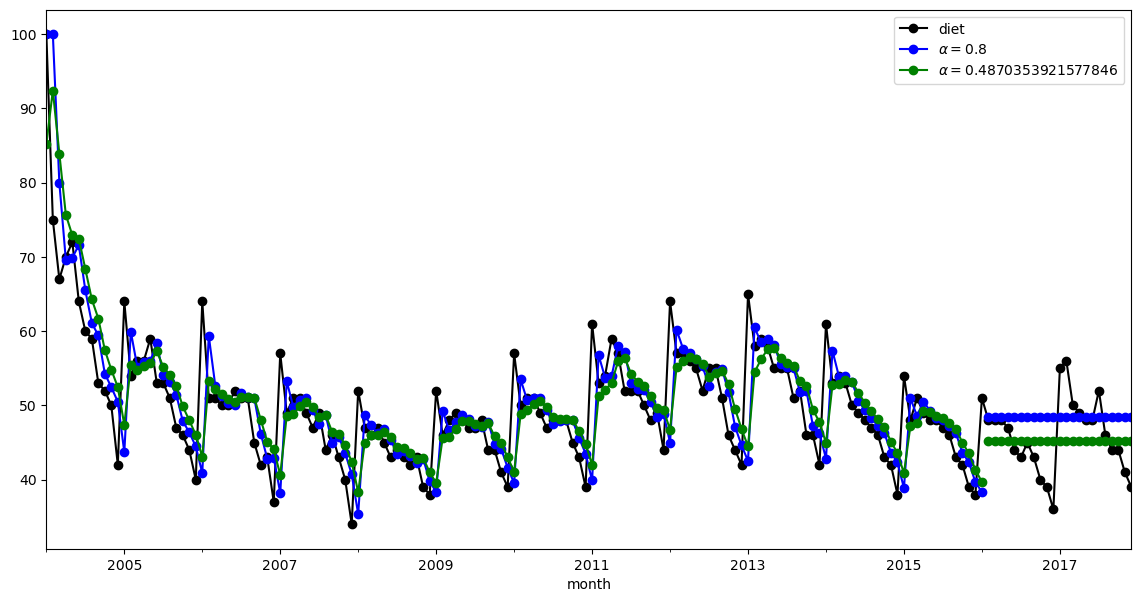

In [30]:
ses(diet, diet_to_train,diet_to_test,0.8,predict_length)

La visualización de los resultados del modelo de previsión de suavizado exponencial simple (SES) muestra la diferencia entre el $\alpha$ especificado (línea azul) y el $\alpha$ autooptimizado (línea verde). Como se puede ver en el gráfico, SES predice una línea de previsión plana, ya que la lógica detrás de ella utiliza promedios ponderados. Aunque el RMSE es bajo, no predice ninguna fluctuación. Dado que la mayoría de los datos de las series temporales tienen algún tipo de tendencia o estacionalidad, este modelo puede utilizarse para obtener una línea de base para la comparación. 

## Método de tendencia lineal de Holt

Adecuado para datos de series temporales con una componente de tendencia pero sin una componente estacional.

Ampliando el método SES, el método Holt le ayuda a pronosticar datos de series temporales que tienen una tendencia. Además del parámetro de suavización de nivel $\alpha$ introducido con el método SES, el método Holt añade el parámetro de suavización de tendencia $\beta$. Al igual que con el parámetro $\alpha$, el rango de $\beta$ también está entre 0 y 1.

El código de ejemplo que aparece a continuación contiene dos variantes diferentes dentro del método Holt. Ambos ajustes tienen como valores de los parámetros $\alpha=0.6$, $\beta=0.2$. El ajuste1 (`fit1`) es el modelo aditivo de Holt por defecto, y el ajuste2 (`fit2`) es un modelo exponencial. Un modelo exponencial sería apropiado para situaciones en las que el aumento o la disminución comienzan lentamente pero luego se aceleran rápidamente.

In [31]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_length):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_length).rename("Modelo de tendencia lineal de Holt")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('El error cuadrático medio del modelo de tendencia lineal de Holt es {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_length).rename("Modelo de tendencia exponencial de Holt")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('El error cuadrático medio del modelo de tendencia exponencial de Holt es {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

/home/pedroa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/pedroa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


El error cuadrático medio del modelo de tendencia lineal de Holt es 6.89
El error cuadrático medio del modelo de tendencia exponencial de Holt es 10.32


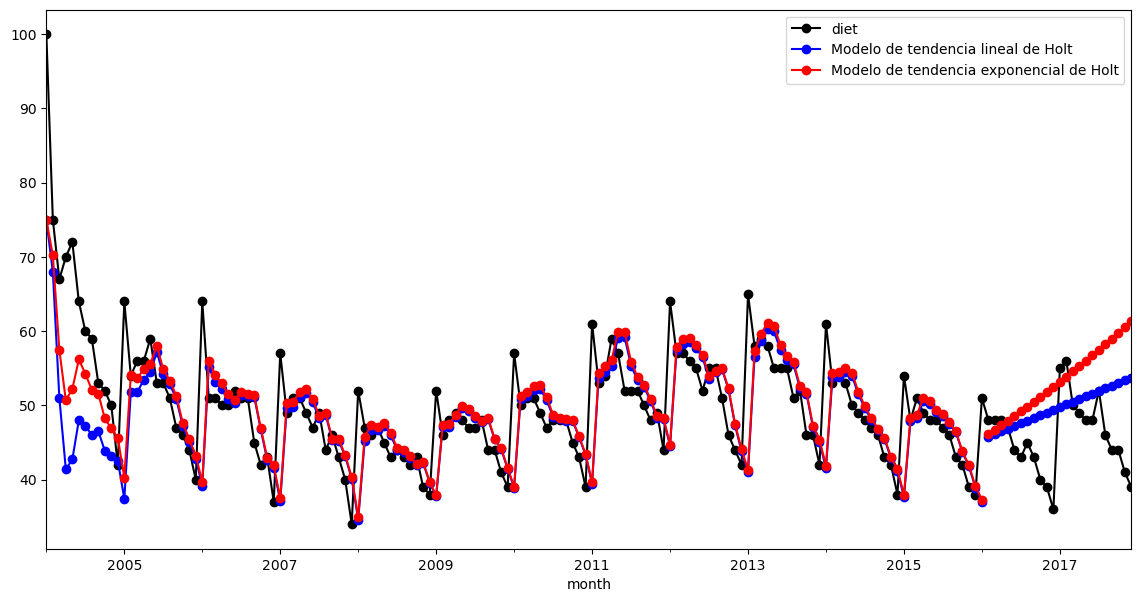

In [32]:
holt(diet, diet_to_train,diet_to_test,0.6,0.2,predict_length)

Al observar la visualización del método Holt, vemos cómo la tendencia lineal (línea azul) y la tendencia exponencial (línea roja) se comparan entre sí. En comparación con SES, Holt capta más la tendencia de los datos. Sin embargo, como se puede ver en el gráfico, la tendencia que descubre es demasiado dramática y sería muy poco probable que tuviera lugar en la vida real.

## Método estacional de Holt-Winters
Adecuado para datos de series temporales con componentes de tendencia y/o estacional.

El modelo de Holt-Winters amplía al de Holt para permitir la previsión de datos de series temporales que tienen tanto tendencia como estacionalidad. Así, incluimos un parámetro de suavización de la estacionalidad: $\gamma$.

Hay dos tipos generales de estacionalidad: Aditiva y Multiplicativa. 
- *Aditiva*: `x = Tendencia + Estacionalidad + Aleatorio`. Los cambios estacionales en los datos se mantienen más o menos igual a lo largo del tiempo y no fluctúan en relación con los datos globales.
- *Multiplicativa*:`xt = Tendencia * Estacional * Aleatorio`. La variación estacional cambia en relación con los cambios generales de los datos. Así, si los datos tienen una tendencia al alza, las diferencias estacionales también crecen proporcionalmente.

Esta es imagen es muy útil:
![Imagen que muestra los gráficos aditivos VS multiplicativos](./pics/additive-vs-multiplicative.png)
Fuente: [Sigmundo Preissler Jr, PhD](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7)

Una vez que sepamos que tipo de estacionalidad tienen nuestros datos, debemos identificar el periodo de la estacionalidad o $s$. En nuestro caso, como ya vimos, la estacionalidad tiene periodo $s=12$ meses.

El módulo Python `statsmodels` proporciona a los usuarios una gama de combinaciones de parámetros basados en los tipos de tendencia, tipos de estacionalidad y otras opciones para hacer transformaciones Box-Cox. Este paquete es algo así como la versión de series de tiempo de la búsqueda Grid para el ajuste de hiperparámetros. Para saber más, consultad esta [documentación](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html) y esta [explicación detallada](https://otexts.com/fpp2/holt-winters.html) que nos ayuda a elegir lo que mejor se adapta a los datos.

In [33]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_length):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', use_boxcox=True).fit()
        fcast1 = fit1.forecast(predict_length).rename('Aditiva')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('Error cuadrático medio de una tendencia aditiva, estacionalidad aditiva con '+ 
              'un periodo season_length={} y una transformación Box-Cox {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True, use_boxcox=True).fit()
        fcast2 = fit2.forecast(predict_length).rename('Aditiva amortiguada')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('Error cuadrático medio de una tendencia aditiva amortiguada, estacionalidad aditiva con '+ 
              'un periodo season_length={} y una transformación Box-Cox {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', use_boxcox=True).fit()
        fcast3 = fit3.forecast(predict_length).rename('Multiplicativa')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('Error cuadrático medio de una tendencia aditiva, estacionalidad multiplicativa con '+ 
              'un periodo season_length={} y una transformación Box-Cox {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True, use_boxcox=True).fit()
        fcast4 = fit4.forecast(predict_length).rename('Multiplicativa amortiguada')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('Error cuadrático medio de una tendencia aditiva amortiguada, estacionalidad multiplicativa con '+ 
              'un periodo season_length={} y una transformación Box-Cox {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Tipo estacional inválido. Escoger entre \'additive\' o \'multiplicative\'')

    plt.show()

/home/pedroa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/pedroa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  
/home/pedroa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Error cuadrático medio de una tendencia aditiva, estacionalidad aditiva con un periodo season_length=12 y una transformación Box-Cox 4.79
Error cuadrático medio de una tendencia aditiva amortiguada, estacionalidad aditiva con un periodo season_length=12 y una transformación Box-Cox 4.42


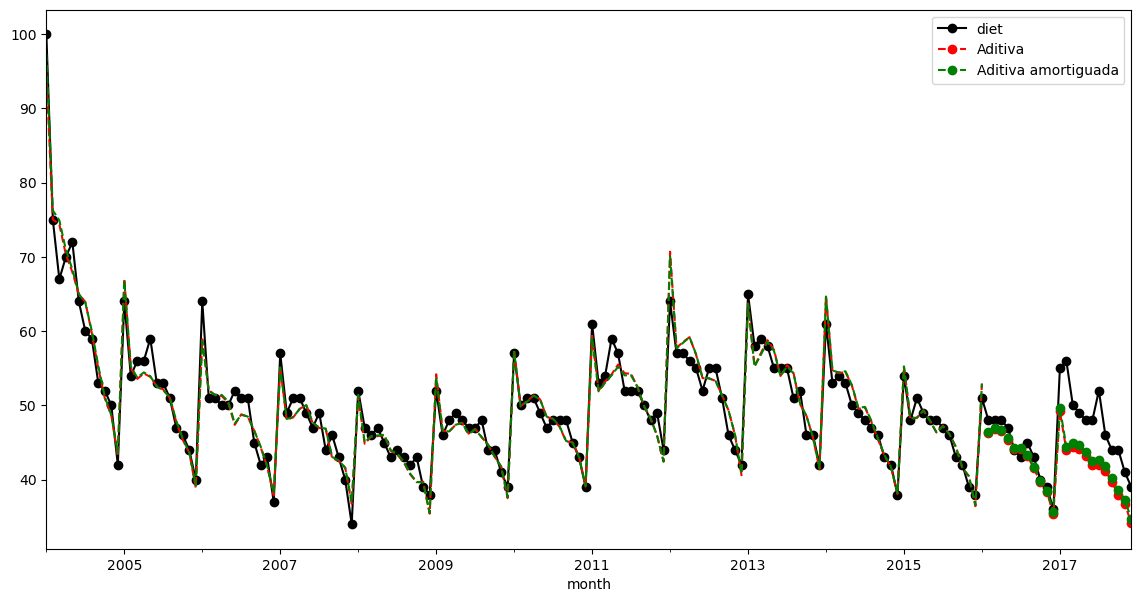

In [34]:
holt_win_sea(diet, diet_to_train,diet_to_test,'additive',12, predict_length)


## Predicción de series temporales utilizando modelos AutoRegressive Moving Average (ARMA)

Inspirado en:

- https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781783553358/7/ch07lvl1sec77/arma-models

- http://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model

- ARIMA: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

Mientras que los modelos de suavización exponencial utilizan medias ponderadas de observaciones pasadas para predecir nuevos valores, los modelos de AR y MA tienen en cuenta las autocorrelaciones o las correlaciones de serie temporal. En otras palabras, los modelos ARMA examinan las diferencias entre los valores de las series temporales.

Los modelos ARMA se suelen utilizar a menudo como herramienta para predecir valores de un ST.
Estos modelos combinan una parte AutoRegresiva (AR) con una parte de medias móviles (Moving Average, MA).
En los modelos MA, asumimos que una variable es la suma de la media de la serie temporal y una combinación lineal de componentes de ruido.

Los modelos AR y MA pueden tener distinto orden. En general, podemos definir un modelo ARMA con $p$ términos autorregresivos y $q$ términos de medias móviles de la siguiente forma:

$$
X_t = \sum_i^p \phi_i X_{t-i} +\sum_i^q \theta_i a_{t-i} + a_t
$$

### Eligiendo $p$ y $q$

Lo primero que deberíamos hacer es representar las funciones de correlación parcial (PACF) para $p$ y las funciones de correlación (ACF) para $q$.

La función de autocorrelación parcial (PACF) mide la correlación entre la ST en una versión retardada de sí misma pero eliminando antes la varianza ya explicada por retardos anteriores. Por ejemplo, si medimos el PACF para un $lag=5$ tendremos en cuenta la correlación con los valores de la serie de hace 5 instantes de tiempo, pero eliminando la varianza ya explicada por los restardos 1, 2, 3 y 4.

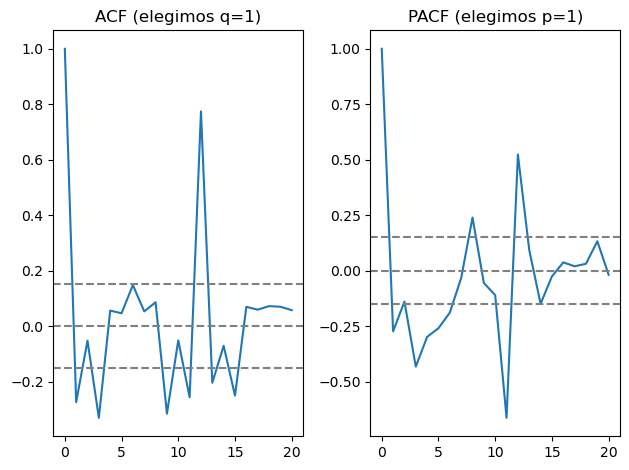

In [35]:
from statsmodels.tsa.stattools import acf, pacf

x = df["gym"].astype(float)

x_diff = x.diff().dropna() # El primer término será NA

# Valores ACF y PACF:
lag_acf = acf(x_diff, nlags=20, fft=True)
lag_pacf = pacf(x_diff, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.title('ACF (elegimos q=1)')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.title('PACF (elegimos p=1)')
plt.tight_layout()

En este gráfico, las dos líneas discontinuas a ambos lados del 0 son intervalos de confianza. Estos intervalos se usan para seleccionar $p$ y $q$ de la siguiente forma:

- $p$: elegir el valor del desfase a partir del cual el PACF cruza el valor superior del intervalo de confianza la primera vez. En este caso $p=1$.

- $q$: elegir el valor del desfase a partir del cual el ACF cruza el valor superior del intervalo de confianza la primera vez. En este caso $q=1$.

### Entrenar un modelos ARMA con statsmodels

1. Definir el modelo llamando a `ARMA()` y dándole los valores de $p$ y de $q$.

2. Entrenar el modelo usando el conjunto de entrenamiento a partir del método `fit()`.

3. Realizar las predicciones llamando a `predict()` el índice de los instantes de tiempo a predecir.

/home/pedroa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/pedroa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/pedroa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    gym   No. Observations:                  168
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -436.852
Date:                Fri, 01 Mar 2024   AIC                            881.704
Time:                        06:51:50   BIC                            894.200
Sample:                    01-01-2004   HQIC                           886.776
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4287     14.339      2.541      0.011       8.325      64.532
ar.L1          0.9967      0.007    152.509      0.000       0.984       1.009
ma.L1         -0.7494      0.065    -11.568      0.0

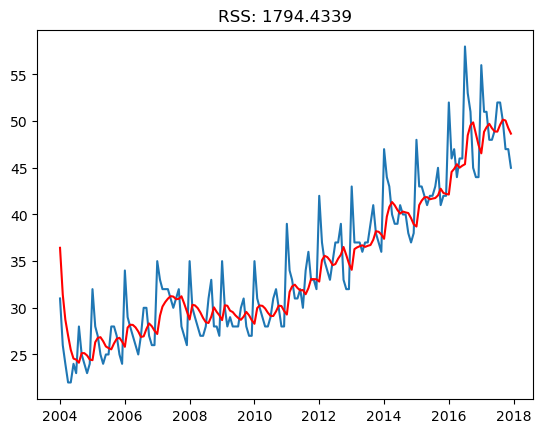

In [36]:
from statsmodels.tsa.arima.model import ARIMA

# Modelo más general Seasonal ARIMA multiplicativo SARIMAX(p,d,q)x(P,D,Q,s)
# order=(p,d,q) seasonal_order(P,D,Q,s)
model = ARIMA(x, order=(1, 0, 1), seasonal_order=(0,0,0,0)).fit() # fit model

print(model.summary())
plt.plot(x)
plt.plot(model.predict(), color='red')
plt.title('RSS: %.4f'% sum((model.fittedvalues-x)**2));

## Modelos SARIMA

Adecuados para datos de series temporales con componentes de tendencia y/o estacionales.

SARIMA se basa en el concepto de ARIMA pero lo amplía para modelar las componentes estacionales de los datos. Observaréis que SARIMA incluye varios parámetros que pueden ajustarse para lograr un rendimiento óptimo. Podéis obtener más información sobre estos parámetros [aquí](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/). Son los siguientes: 
- Elementos de tendencia:

   - $p$: Orden de autoregresión de tendencia.
   - $d$: Orden de diferencia de tendencia.
   - $q$: Orden de media móvil de tendencia.

- Elementos estacionales:
   - $P$: Orden de autorregresión estacional.
   - $D$: Orden de diferencia estacional.
   - $Q$: Orden de media móvil estacional.

- $s$: Periodo para la parte estacional.

Para obtener la mejor predicción, es importante encontrar los valores de $SARIMA(p,d,q)(P,D,Q)s$ que optimicen una métrica de interés. Para los propósitos de este tutorial, utilizaremos una "búsqueda en cuadrícula" para explorar iterativamente diferentes combinaciones de parámetros.

La métrica de evaluación que utilizaremos para la búsqueda en la cuadrícula es el valor AIC (Criterio de Información de Akaike). El AIC mide lo bien que un modelo se ajusta a los datos teniendo en cuenta la complejidad general del modelo. En general, queremos elegir la combinación con el valor AIC más bajo.

In [37]:
import itertools
import statsmodels.api as sm
import warnings

# Ignoramos los warnings 
warnings.filterwarnings("ignore")

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit(disp=False)
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

                print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                print(param)
                print(param_seasonal)
                continue
    print('El conjunto de parámetros con mínimo AIC es: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [38]:
sarima_grid_search(diet_to_train,12)

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1539.7117166318878
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1270.1636301064586
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:779.2364488733294
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:639.4551059178968
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:814.4579980516494
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:757.1494598689427
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:645.5524713102621
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:633.7901729363456
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1373.823517864358
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1120.7795965476673
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:680.5706714280482
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:593.3168200400526
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:740.8383506394011
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:674.4582765554505
SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:603.2449729681533
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:584.0622836866655
SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:946.1555770864771
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:757.4273302550714
SARIMA(0, 1, 0)x(0, 1, 0,

Parece que la combinación de parámetros óptima es `SARIMA(0, 1, 1)x(1, 1, 1, 12)` (menor valor de AIC). Así que vamos a usarla para terminar de entrenar el modelo.

In [39]:
# Llamar a esta función después de obtener la mejor combinación de parámetros en función del AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # Entrenar el modelo 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # El argumento dynamic=False asegura que realizamos predicciones a un instante de tiempo, 
    # de manera que para cada punto usamos todas las observaciones disponibles hasta ese punto.
    # Con dynamic=Fecha las predicciones de la fase de test se construyen en base a las propias
    # predicciones del modelo (no en base a los valores observados)
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('El RMSE de un modelo SARIMA con season_length={} y dynamic = False es {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observado')
    y_forecasted.plot(ax=ax, label='Predicciones en base a valores observados', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Fecha')
    ax.set_ylabel('Trend')
    plt.legend()
    plt.show()

    # Una mejor idea de la capacidad predictiva puede obtenerse usando predicciones dinámicas.
    # En este caso solo usamos las observaciones hasta un determinado instante temporal y
    # después las predicciones se generan a partir de predicciones pasadas. 
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('El RMSE de un modelo SARIMA con season_length={} y dynamic = True es {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observado')
    y_forecasted_dynamic.plot(label='Predicción dinámica', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Fecha')
    ax.set_ylabel('Trend')

    plt.legend()
    plt.show()
    
    return (results)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91086D+00    |proj g|=  1.17063D-01


 This problem is unconstrained.



At iterate    5    f=  1.81909D+00    |proj g|=  8.13104D-02

At iterate   10    f=  1.81523D+00    |proj g|=  2.59117D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   2.292D-05   1.815D+00
  F =   1.8152250056791313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5849      0.066     -8.891      0.000      -0.714      -0.456
ar.S.L12       0.1878      0.077      2.450      0.014       0

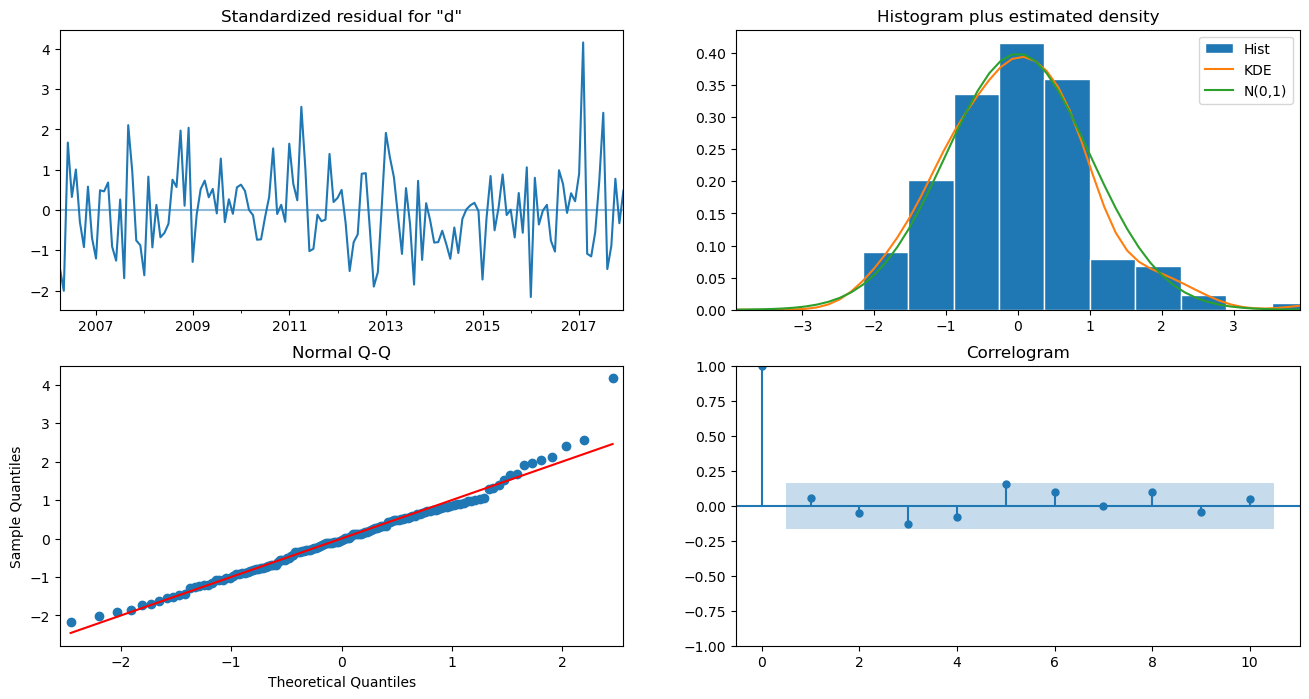

El RMSE de un modelo SARIMA con season_length=52 y dynamic = False es 2.55


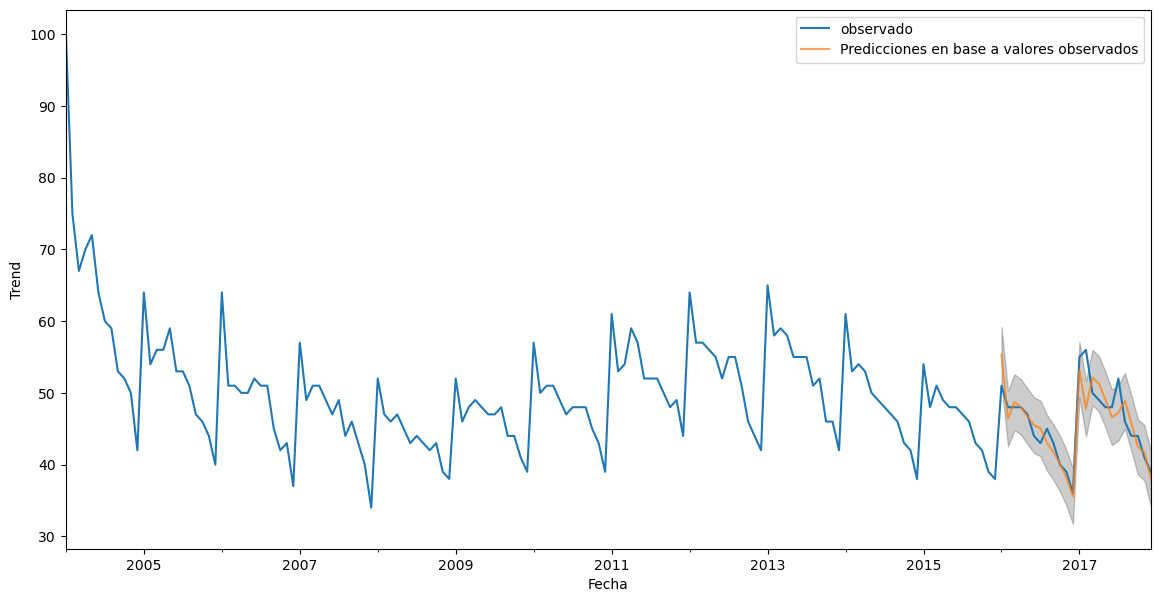

El RMSE de un modelo SARIMA con season_length=52 y dynamic = True es 2.59


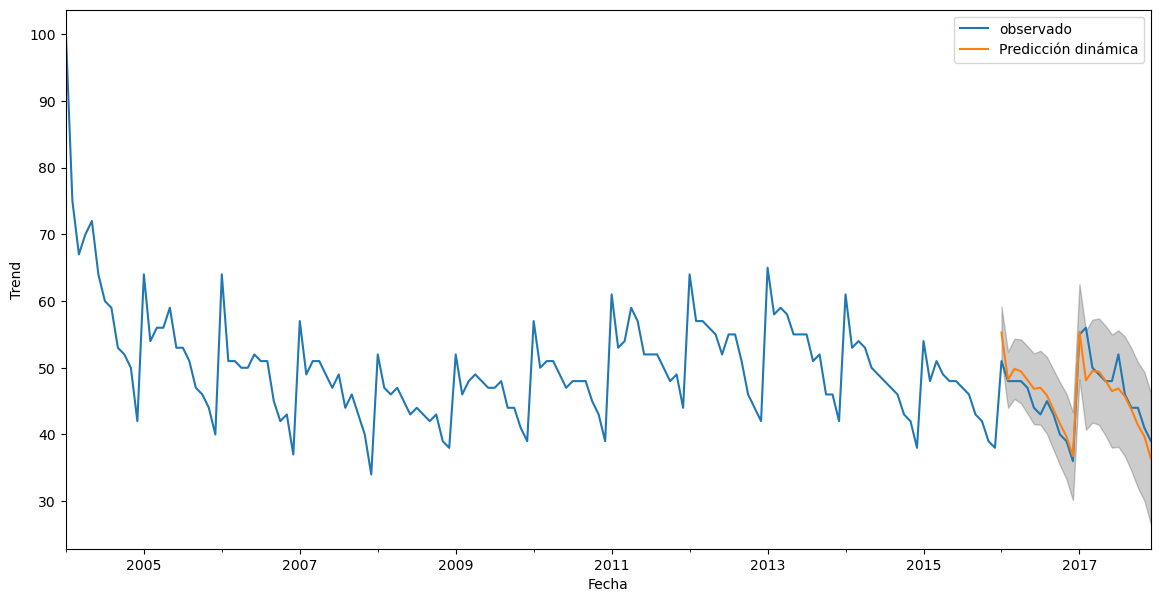

In [40]:
model = sarima_eva(diet,(0, 1, 1),(1, 1, 1, 12),52,predict_date,diet_to_test)